In [ ]:
! pip install hiddenlayer graphviz torchviz

     |████████████████████████████████| 51kB 2.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=ca7ad615a188fcf4865ec3d8f0bdce1c431a43f322315ecd05c99571f98c5fac
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest


torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)


In [2]:
# check availability of GPU and set the device accordingly

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# define a transforms for preparing the dataset
transform = transforms.Compose([
        transforms.CenterCrop(26),
        transforms.Resize((28,28)),
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomRotation(10),      
        transforms.RandomAffine(5),
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,)) # normalise the images with mean and std of the dataset
        ])

In [3]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above

train_dataset = datasets.MNIST('./data',train=True,transform=transform,download=True)
test_dataset =  datasets.MNIST('./data',train=False,transform=transform,download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set

train_dataloader = Data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)


In [5]:
# My Net

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv11 = nn.Conv2d(1, 16, 3, 1) # Input = 1x28x28  Output = 16x26x26
        self.conv12 = nn.Conv2d(1, 16, 5, 1) # Input = 1x28x28  Output = 16x24x24
        self.conv13 = nn.Conv2d(1, 16, 7, 1) # Input = 1x28x28  Output = 16x22x22
        self.conv14 = nn.Conv2d(1, 16, 9, 1) # Input = 1x28x28  Output = 16x20x20

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv21 = nn.Conv2d(16, 32, 3, 1) # Input = 16x26x26 Output = 32x24x24
        self.conv22 = nn.Conv2d(16, 32, 5, 1) # Input = 16x24x24 Output = 32x20x20
        self.conv23 = nn.Conv2d(16, 32, 7, 1) # Input = 16x22x22 Output = 32x16x16
        self.conv24 = nn.Conv2d(16, 32, 9, 1) # Input = 16x20x20  Output = 32x12x12

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv31 = nn.Conv2d(32, 64, 3, 1) # Input = 32x24x24 Output = 64x22x22
        self.conv32 = nn.Conv2d(32, 64, 5, 1) # Input = 32x20x20 Output = 64x16x16
        self.conv33 = nn.Conv2d(32, 64, 7, 1) # Input = 32x16x16 Output = 64x10x10
        self.conv34 = nn.Conv2d(32, 64, 9, 1) # Input = 32x12x12 Output = 64x4x4
        

        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2) # Output = 64x11x11
        #self.maxpool1 = nn.MaxPool2d(1)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)

        # define a linear(dense) layer with 128 output features
        self.fc11 = nn.Linear(64*11*11, 256)
        self.fc12 = nn.Linear(64*8*8, 256)      # after maxpooling 2x2
        self.fc13 = nn.Linear(64*5*5, 256)
        self.fc14 = nn.Linear(64*2*2, 256)

        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc21 = nn.Linear(256, 128)
        self.fc22 = nn.Linear(256, 128)
        self.fc23 = nn.Linear(256, 128)
        self.fc24 = nn.Linear(256, 128)

        self.fc33 = nn.Linear(128*4,10)
        #self.fc33 = nn.Linear(64*3,10)
        

    def forward(self, inp):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        

        x = F.relu(self.conv11(inp))
        x = F.relu(self.conv21(x))
        x = F.relu(self.maxpool(self.conv31(x)))
        #print(x.shape)
        #x = torch.flatten(x, 1)
        x = x.view(-1,64*11*11)
        x = self.dropout1(x)
        x = F.relu(self.fc11(x))
        x = self.dropout2(x)
        x = self.fc21(x)

        y = F.relu(self.conv12(inp))
        y = F.relu(self.conv22(y))
        y = F.relu(self.maxpool(self.conv32(y)))
        #x = torch.flatten(x, 1)
        y = y.view(-1,64*8*8)
        y = self.dropout1(y)
        y = F.relu(self.fc12(y))
        y = self.dropout2(y)
        y = self.fc22(y)

        z = F.relu(self.conv13(inp))
        z = F.relu(self.conv23(z))
        z = F.relu(self.maxpool(self.conv33(z)))
        #x = torch.flatten(x, 1)
        z = z.view(-1,64*5*5)
        z = self.dropout1(z)
        z = F.relu(self.fc13(z))
        z = self.dropout2(z)
        z = self.fc23(z)

        ze = F.relu(self.conv14(inp))
        ze = F.relu(self.conv24(ze))
        ze = F.relu(self.maxpool(self.conv34(ze)))
        #x = torch.flatten(x, 1)
        ze = ze.view(-1,64*2*2)
        ze = self.dropout1(ze)
        ze = F.relu(self.fc14(ze))
        ze = self.dropout2(ze)
        ze = self.fc24(ze)

        out_f = torch.cat((x, y, z, ze), dim=1)
        #out_f1 = torch.cat((out_f, ze), dim=1)
        out = self.fc33(out_f)
        
        output = F.log_softmax(out, dim=1)
        return output

In [6]:
torch.cat((torch.tensor([1,2]),torch.tensor([2,3]),torch.tensor([3,4]),torch.tensor([3,4])),dim=0)

tensor([1, 2, 2, 3, 3, 4, 3, 4])

In [7]:
torch.tensor(1)

tensor(1)

In [8]:
model = Net().to(device)

In [9]:
print(model.parameters)

<bound method Module.parameters of Net(
  (conv11): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv13): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (conv14): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv23): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv24): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv33): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv34): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc11): Linear(in_features=7744, out_feat

In [10]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        #self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

F..
FAIL: test_dataloader (__main__.TestImplementations)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-80e7f3fdfcef>", line 21, in test_dataloader
    self.assertTrue(train_dataloader.batch_size == 32)
AssertionError: False is not true

----------------------------------------------------------------------
Ran 3 tests in 0.044s

FAILED (failures=1)


<unittest.runner.TextTestResult run=3 errors=0 failures=1>

In [11]:
losses_1 = []
losses_2 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses_1.append(loss.item())
            losses_2.append(100. * batch_idx / len(train_loader))
        

In [13]:
accuracy = []
avg_loss = []
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    avg_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

In [14]:


model = Net().to(device)

def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
    torch.nn.init.xavier_normal(m.weight)
    torch.nn.init.zeros_(m.bias)

model.apply(init_weights)  

learning_rate = []
def adjust_learning_rate(optimizer, iter, each):
    # sets the learning rate to the initial LR decayed by 0.1 every 'each' iterations
    lr = 0.001 * (0.95 ** (iter // each))
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    print("Learning rate = ",lr)
    return lr


## Define Adam Optimiser with a learning rate of 0.01
optimizer =  torch.optim.Adagrad(model.parameters(),lr=0.01)

start = timeit.default_timer()
for epoch in range(1,100):
  lr = adjust_learning_rate(optimizer, epoch, 1.616)
  learning_rate.append(lr)
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  import sys


Learning rate =  0.001
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338738
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.216961
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.183171
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.203303
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.177565

Test set: Average loss: 0.0909, Accuracy: 9715/10000 (97%)

Learning rate =  0.00095
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.173545
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.156583
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.072894
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.109094
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.066926

Test set: Average loss: 0.0677, Accuracy: 9785/10000 (98%)

Learning rate =  0.00095
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.097100
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.089464
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.123966
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.083989
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.069083

Test set: Average loss: 0.0558, Accuracy: 9833/10000 (98%)

Learning 

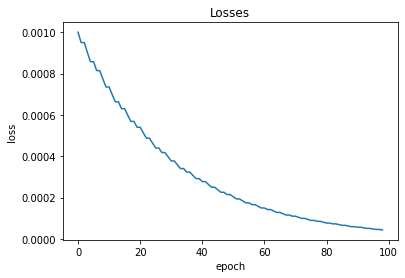

In [15]:
import matplotlib.pyplot as plt
plt.plot(learning_rate, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses');

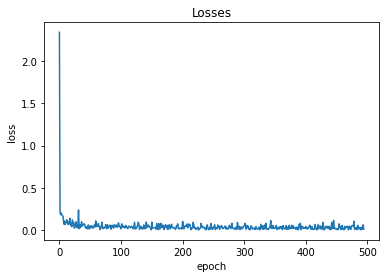

In [16]:
import matplotlib.pyplot as plt
plt.plot(losses_1, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses');

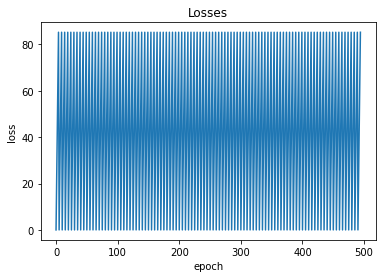

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses_2, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses');

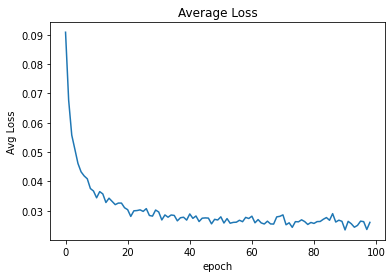

In [18]:
import matplotlib.pyplot as plt
plt.plot(avg_loss, '-')
plt.xlabel('epoch')
plt.ylabel('Avg Loss')
plt.title('Average Loss');

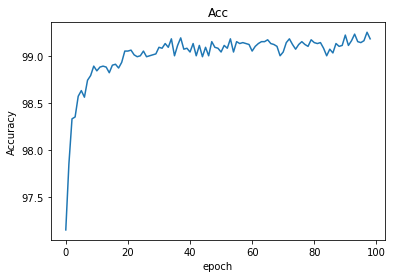

In [19]:
import matplotlib.pyplot as plt
plt.plot(accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Acc');

In [22]:
torch.save(model, '3_model_MNIST_3579_Adagrad_0.95_100e.pth')